# Unit Commitment Problem with Machine Learning
In this notebook, we solve a unit commitment problem for a power system using optimization and machine learning. We use binary classification to predict the on/off status of each generator based on system conditions, aiming to accelerate the unit commitment process.

In [13]:
import numpy as np
from gurobipy import Model, GRB, quicksum
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

## Step 2: Data Preparation - Generating Synthetic Data

## Generate Load data based on nominal load with fluctuate

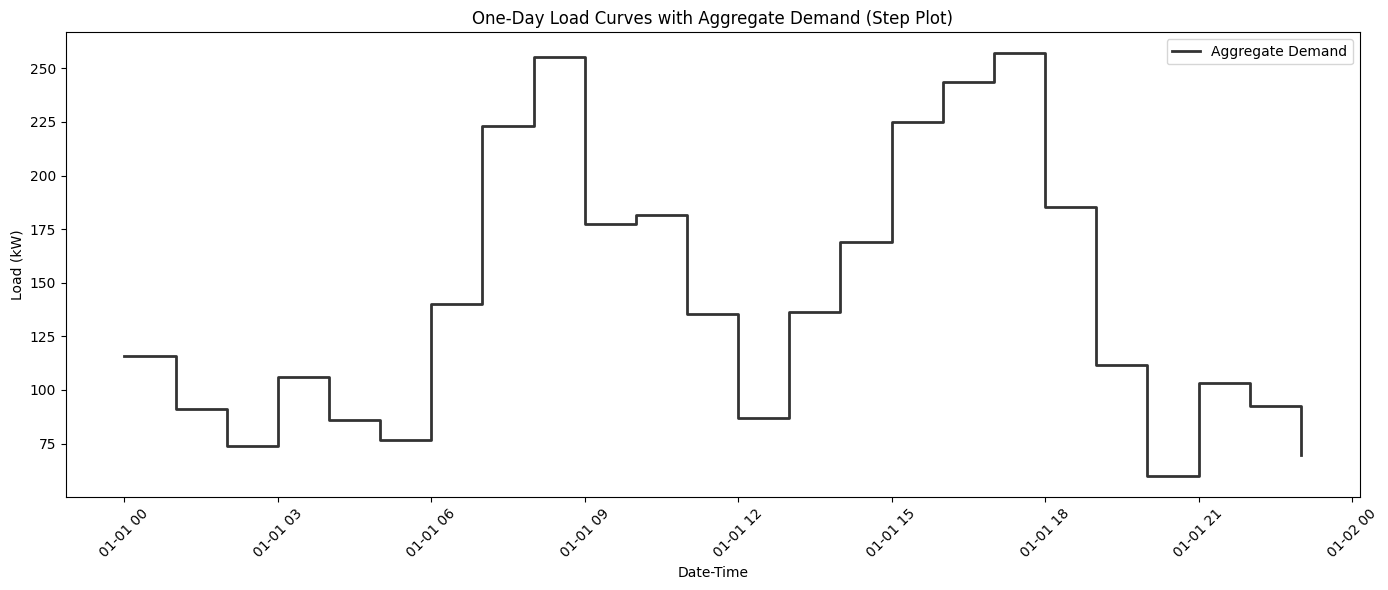

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define constants
nominal_load_1 = 56
nominal_load_2 = 112
nominal_load_3 = 112
hours_per_year = 365 * 24

# Define a 24-hour load profile starting at 12 am for a realistic daily load curve
night_load = [0.3] * 5          # Midnight to 5 am (12 am - 5 am)
morning_peak = [0.3, 0.5, 0.8]  # 6 am - 8 am
daytime_load = [0.8, 0.7, 0.6, 0.5, 0.4, 0.5]         # 9 am - 2 pm
evening_peak = [0.6, 0.8, 0.9, 1]  # 3 pm - 6 pm
late_evening_load = [0.6, 0.4, 0.3]  # 7 pm - 9 pm
night_rest = [0.3] * 3          # 10 pm - 11 pm (wrap back to midnight)

# Combine all segments into a full 24-hour load profile starting from 12 am
daily_base_profile = night_load + morning_peak + daytime_load + evening_peak + late_evening_load + night_rest

# Function to generate a daily load profile with random noise for variability
def generate_random_daily_profile(base_profile, nominal_load, noise_level=0.1):
    noise = np.random.normal(0, noise_level, len(base_profile))  # Add random noise
    profile_with_noise = np.array(base_profile) + noise
    return np.clip(profile_with_noise * nominal_load, 20, nominal_load)  # Ensure non-negative values

# Generate hourly data for one year with daily variability for each load
yearly_load_curve_1, yearly_load_curve_2, yearly_load_curve_3 = [], [], []

for _ in range(365):  # Generate data for each day
    daily_profile_1 = generate_random_daily_profile(daily_base_profile, nominal_load_1)
    daily_profile_2 = generate_random_daily_profile(daily_base_profile, nominal_load_2)
    daily_profile_3 = generate_random_daily_profile(daily_base_profile, nominal_load_3)
    yearly_load_curve_1.extend(daily_profile_1)
    yearly_load_curve_2.extend(daily_profile_2)
    yearly_load_curve_3.extend(daily_profile_3)

# Create timestamps for each hour in the year
timestamps = pd.date_range(start="2019-01-01", periods=hours_per_year, freq="H")

# Create DataFrame with the generated data and calculate the aggregate demand
load_data_aligned = pd.DataFrame({
    "Timestamp": timestamps,
    "Hourly_Load_1": yearly_load_curve_1,
    "Hourly_Load_2": yearly_load_curve_2,
    "Hourly_Load_3": yearly_load_curve_3,
})

# Calculate the aggregate demand

load_data_aligned["Aggregate_Demand"] = (
    load_data_aligned["Hourly_Load_1"] +
    load_data_aligned["Hourly_Load_2"] +
    load_data_aligned["Hourly_Load_3"]
)

# Plot a one-day sample (24 hours) with step plots to show individual loads and aggregate demand
plt.figure(figsize=(14, 6))
#plt.step(load_data_aligned["Timestamp"][:24], load_data_aligned["Hourly_Load_1"][:24], where="post", label="Load Curve 1 (56 kW)", alpha=0.8)
#plt.step(load_data_aligned["Timestamp"][:24], load_data_aligned["Hourly_Load_2"][:24], where="post", label="Load Curve 2 (112 kW)", alpha=0.8)
#plt.step(load_data_aligned["Timestamp"][:24], load_data_aligned["Hourly_Load_3"][:24], where="post", label="Load Curve 3 (112 kW)", alpha=0.8)
plt.step(load_data_aligned["Timestamp"][:24], load_data_aligned["Aggregate_Demand"][:24], where="post", label="Aggregate Demand", color="black", linewidth=2, alpha=0.8)
plt.xlabel("Date-Time")
plt.ylabel("Load (kW)")
plt.title("One-Day Load Curves with Aggregate Demand (Step Plot)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## Generate Wind Power data from Website

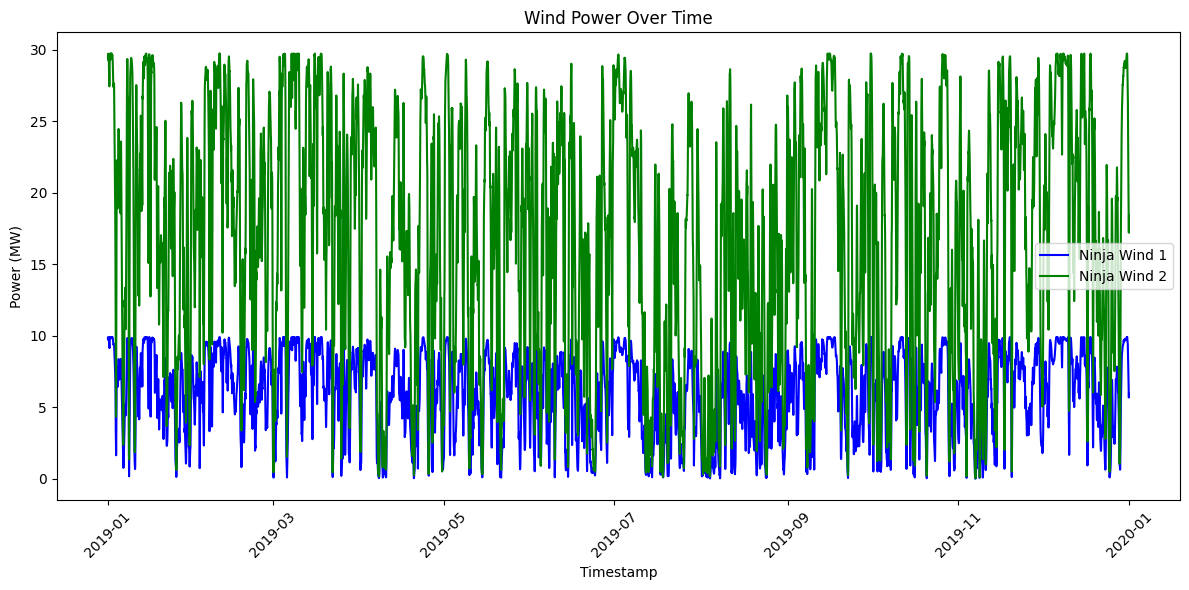

                     N1  N2  N3         N4         N5         N6
2019-01-01 00:00:00   0   0   0  10.133000  17.940543  48.183164
2019-01-01 01:00:00   0   0   0  10.106000  12.405265  28.924980
2019-01-01 02:00:00   0   0   0  10.087000   1.235158  22.879144
2019-01-01 03:00:00   0   0   0  10.112000  14.962361  41.459377
2019-01-01 04:00:00   0   0   0  10.295000   8.489749  27.986616
...                  ..  ..  ..        ...        ...        ...
2019-12-31 19:00:00   0   0   0  18.597431   9.074094  36.980312
2019-12-31 20:00:00   0   0   0  13.661599  27.242417  51.118264
2019-12-31 21:00:00   0   0   0  20.655121  27.310949  29.817713
2019-12-31 22:00:00   0   0   0  14.316000   8.925285  36.588091
2019-12-31 23:00:00   0   0   0  15.050236   1.568000  34.657335

[8760 rows x 6 columns]


In [15]:
dates = pd.date_range(start="2019-01-01", periods=hours_per_year, freq="H")
ninja_wind_1 = pd.read_csv(r"Assignment 2/ninja_wind_55.0582_15.1174_10.csv")
ninja_wind_2 = pd.read_csv(r"Assignment 2/ninja_wind_55.2402_14.7831_30.csv")

# Rename 'time' column to 'Timestamp' in both datasets for consistency
ninja_wind_1.rename(columns={"time": "Timestamp"}, inplace=True)
ninja_wind_2.rename(columns={"time": "Timestamp"}, inplace=True)

# Convert 'Timestamp' columns to datetime format
ninja_wind_1['Timestamp'] = pd.to_datetime(ninja_wind_1['Timestamp'], format='%Y/%m/%d %H:%M')
ninja_wind_2['Timestamp'] = pd.to_datetime(ninja_wind_2['Timestamp'], format='%Y/%m/%d %H:%M')

plt.figure(figsize=(12, 6))
plt.plot(ninja_wind_1['Timestamp'], ninja_wind_1['power'], label='Ninja Wind 1', color='blue')
plt.plot(ninja_wind_2['Timestamp'], ninja_wind_2['power'], label='Ninja Wind 2', color='green')

# Adding title and labels
plt.title('Wind Power Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Power (MW)')  # Adjust the unit if different

# Show legend
plt.legend()

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Merging all data based on 'Timestamp'
merged_data = pd.merge(load_data_aligned, ninja_wind_1, on="Timestamp", how="outer")
merged_data = pd.merge(merged_data, ninja_wind_2, on="Timestamp", how="outer", suffixes=('_W1', '_W2'))

merged_data['N1'] = 0
merged_data['N2'] = 0
merged_data['N3'] = 0
merged_data['N4'] = merged_data['Hourly_Load_1'] - merged_data['power_W1']
merged_data['N5'] = merged_data['Hourly_Load_2'] - merged_data['power_W2']
merged_data['N6'] = merged_data['Hourly_Load_3']

# Convert specified columns to dictionary format
merged_data_dict = {
    "N1": merged_data["N1"].tolist(),
    "N2": merged_data["N2"].tolist(),
    "N3": merged_data["N3"].tolist(),
    "N4": merged_data["N4"].tolist(),
    "N5": merged_data["N5"].tolist(),
    "N6": merged_data["N6"].tolist()
}


D_nt_df = pd.DataFrame(merged_data_dict, index=timestamps)

# value = D_nt_df.loc["2019-01-01 01:00:00", "N4"]
print(D_nt_df )



## Step 1 Optimization For signal day

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[x86] - Darwin 23.5.0 23F79)

CPU model: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1256 rows, 671 columns and 7308 nonzeros
Model fingerprint: 0xfc7cb455
Variable types: 576 continuous, 95 integer (95 binary)
Coefficient statistics:
  Matrix range     [7e-02, 9e+02]
  Objective range  [1e+00, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 3e+02]
Found heuristic solution: objective 2.534851e+07
Presolve removed 352 rows and 175 columns
Presolve time: 0.02s
Presolved: 904 rows, 496 columns, 5747 nonzeros
Variable types: 344 continuous, 152 integer (152 binary)

Root relaxation: objective 8.072761e+05, 189 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 80727

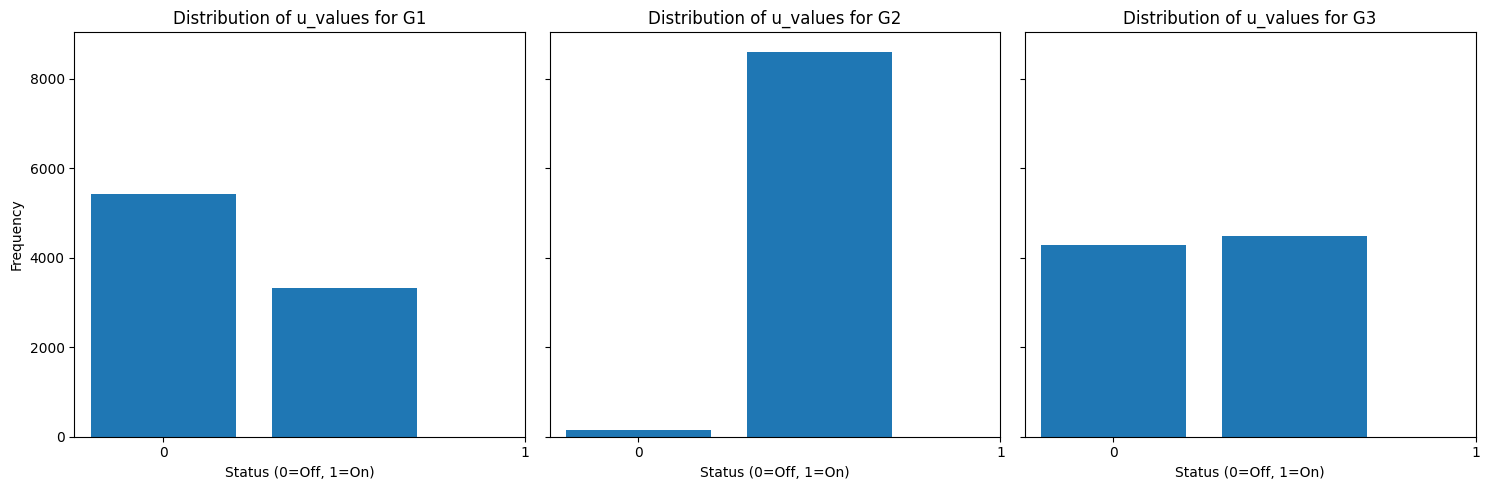

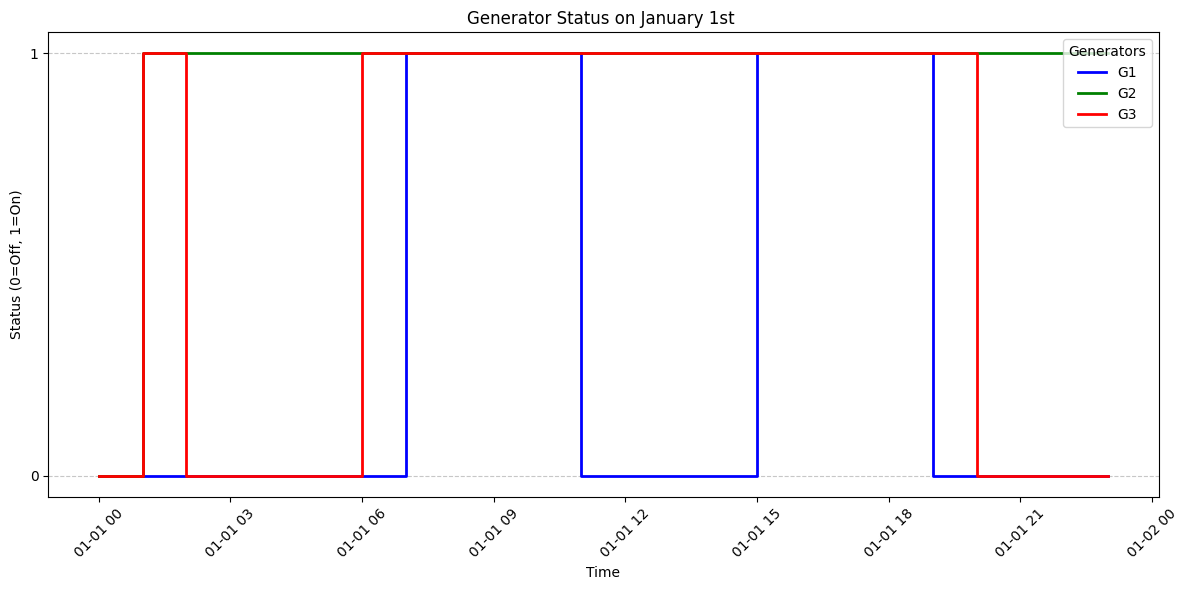

In [17]:
G = ["G1", "G2", "G3"] 
T = dates
# T = dates[:4 * 24]
daily_time_blocks = [T[i:i+24] for i in range(0, len(T), 24)]

N = ["N1", "N2", "N3", "N4", "N5", "N6"] 
L = ["L1", "L2", "L3", "L4", "L5", "L6", "L7"]

B = [
    [0, -0.68197, -0.65018, -0.48266, -0.51445, -0.63472],
    [0, 0.146043, -0.75311, -0.22164, -0.32249, -0.70405],
    [0, -0.31803, -0.34982, -0.51734, -0.48555, -0.36528],
    [0, 0.17199, 0.102932, -0.26102, -0.19196, 0.069337],
    [0, -0.14604, -0.24689, 0.221642, -0.67751, -0.29595],
    [0, -0.14604, -0.24689, 0.221642, 0.322485, -0.29595],
    [0, 0.146043, 0.246886, -0.22164, -0.32249, -0.70405]
]
max_production = [220, 100, 70]
transmission_capacity = [200, 100, 100, 100, 100, 100, 100]
min_down_time = [4,2,1]
min_production = [100, 10, 10]
min_up_time = [4,3,1]
production_cost = [20.655, 16.7, 22.545]
ramping_rate = [55, 50, 20]
start_up_cost = [900, 550, 170]

generator_data = pd.DataFrame({
    'Max_Production': max_production,
    'Min_Down_Time': min_down_time,
    'Min_Production': min_production,
    'Min_Up_Time': min_up_time,
    'Production_Cost': production_cost,
    'Ramping_Rate': ramping_rate,
    'Start_Up_Cost': start_up_cost
}, index=G)

B_df = pd.DataFrame(B, index=L, columns=N)
transmission_capacity_df = pd.DataFrame({
    'Transmission_Capacity': transmission_capacity
}, index=L)

Load_1 = merged_data['Hourly_Load_1']
Load_2 = merged_data['Hourly_Load_2']
Load_3 = merged_data['Hourly_Load_3']
P_W1 = merged_data['power_W1']
P_W2 = merged_data['power_W2']

u_values = {}
p_values = {}
daily_min_costs = []

# 定义一个字典来存储每小时的Transmission Limitation值
transmission_values = {}

day = 0  
daily_T = daily_time_blocks[0]
# for day, daily_T in enumerate(daily_time_blocks[0:4]):
for day, daily_T in enumerate(daily_time_blocks):
    model = Model(f"DailyOptimization_Day{day+1}")

    M = 10000

    # p, p_nt
    p = model.addVars(G, daily_T, lb=0, name="p")
    p_nt = model.addVars(N, daily_T, lb=0, name="p_nt")
    u = model.addVars(G, daily_T, vtype=GRB.BINARY, name="u")    # on/off
    s = model.addVars(G, daily_T, lb=0, name="s")                # start-up cost
    epsilon = model.addVars(N, daily_T, lb=0, name="epsilon") 
    delta = model.addVars(N, daily_T, lb=0, name="delta")
    first_hour = daily_T[0]
    last_hour_previous_day = daily_time_blocks[day - 1][-1] if day > 0 else None

    if day > 0:  
        for g in G:
            model.addConstr(u[g, first_hour] == u_values[(g, last_hour_previous_day)], 
                            name=f"Set_{g}_u_first_hour_equal_last_hour_previous_day_Day{day+1}")
            
    else:
        
        model.addConstr(u["G1", first_hour] == 0, name=f"Set_G1_u_first_hour_0_Day{day+1}")
        model.addConstr(u["G2", first_hour] == 0, name=f"Set_G2_u_first_hour_0_Day{day+1}")
        model.addConstr(u["G3", first_hour] == 0, name=f"Set_G3_u_first_hour_0_Day{day+1}")

    # Objective function
    model.setObjective(
        (quicksum((generator_data.loc[g, 'Production_Cost'] * p[g, t] + s[g, t]) for g in G for t in daily_T) + 
        M * quicksum(epsilon[n, t] + delta[n, t] for n in N for t in daily_T)),
        GRB.MINIMIZE
    )
    # Constraints for generation
    for g in G:
        for t in daily_T:
            model.addConstr(generator_data.loc[g, 'Min_Production'] * u[g, t] <= p[g, t])
            model.addConstr(p[g, t] <= generator_data.loc[g, 'Max_Production'] * u[g, t])

    # balancing constraint
    for t in daily_T:
        model.addConstr(quicksum(p[g, t] for g in G) == quicksum(D_nt_df.loc[t, n] + epsilon[n, t] - delta[n, t] for n in N))
        
    # Transmission limitation with value tracking
    for l in L:
        for t in daily_T:
            
            transmission_expr = quicksum(B_df.loc[l, n] * (p_nt[n, t] - D_nt_df.loc[t, n] - epsilon[n, t] + delta[n, t]) for n in N)
            
            
            model.addConstr(transmission_expr >= -transmission_capacity_df.loc[l, 'Transmission_Capacity'], 
                            name=f"Transmission_Limitation_Lower_{l}_{t}")
            model.addConstr(transmission_expr <= transmission_capacity_df.loc[l, 'Transmission_Capacity'], 
                            name=f"Transmission_Limitation_Upper_{l}_{t}")
            
            transmission_values[(l, t)] = transmission_expr
            

    # combine p_gt with p_nt
    for t in daily_T:
        model.addConstr(p_nt["N1", t] == p["G1", t], name=f"Link_G1_N1_t{t}")
        model.addConstr(p_nt["N2", t] == p["G2", t], name=f"Link_G2_N2_t{t}")
        model.addConstr(p_nt["N6", t] == p["G3", t], name=f"Link_G3_N6_t{t}")
        model.addConstr(p_nt["N3", t] == 0, name=f"Set_N3_Zero_t{t}")
        model.addConstr(p_nt["N4", t] == 0, name=f"Set_N4_Zero_t{t}")
        model.addConstr(p_nt["N5", t] == 0, name=f"Set_N5_Zero_t{t}")

    # start-up constraint
    for g in G:
        for t_idx, t in enumerate(daily_T):
            if t_idx == 0:
               continue
            else:
                # if t>0 use data in same day
                prev_t = daily_T[t_idx - 1]
                model.addConstr(s[g, t] >= generator_data.loc[g, 'Start_Up_Cost'] * (u[g, t] - u[g, prev_t]))

    # ramping rate constraint
    for g in G:
        if g == "G1":
            for t_idx, t in enumerate(daily_T):
                if t_idx == 0:
                    continue
                else:
                    prev_t = daily_T[t_idx - 1]
                    w = model.addVar(vtype=GRB.BINARY, name=f"w_{g}_{t}")
                    model.addConstr(w <= u[g, t])
                    model.addConstr(w <= u[g, prev_t])
                    model.addConstr(w >= u[g, t] + u[g, prev_t] - 1)
                    ramping_rate = generator_data.loc[g, 'Ramping_Rate']
                    penalty = 45 * (1 - w)
                    model.addConstr(p[g, t] - p[g, prev_t] >= -ramping_rate - penalty)
                    model.addConstr(p[g, t] - p[g, prev_t] <= ramping_rate + penalty)  
        else:
            for t_idx, t in enumerate(daily_T):
                if t_idx == 0:
                    continue
                else:
                    prev_t = daily_T[t_idx - 1]
                    model.addConstr(p[g, t] - p[g, prev_t] >= -generator_data.loc[g, 'Ramping_Rate'])
                    model.addConstr(p[g, t] - p[g, prev_t] <= generator_data.loc[g, 'Ramping_Rate'])
    # min-up-time constraint
    for g in G:
        for t_idx, t in enumerate(daily_T):
            max_t_in_day = daily_T[-1]
            tau_range = pd.date_range(
            start=t, 
            end=min(t + pd.Timedelta(hours=generator_data.loc[g, 'Min_Up_Time'] - 1), max_t_in_day), 
            freq='H'
        )
            # if it is the first hour of the day
            if t_idx == 0:
                continue
            else:
                # if not the first hour of the day
                prev_t = daily_T[t_idx - 1]
                for tau in tau_range:
                    model.addConstr(
                        -u[g, prev_t] + u[g, t] - u[g, tau] <= 0
                    )
    # min-down-time constraint
    for g in G:
        for t_idx, t in enumerate(daily_T):
            max_t_in_day = daily_T[-1]
            tau_range = pd.date_range(
            start=t, 
            end=min(t + pd.Timedelta(hours=generator_data.loc[g, 'Min_Down_Time'] - 1), max_t_in_day), 
            freq='H'
        )
            # if it is the first hour of the day
            if t_idx == 0:
                continue
            else:
                # if not the first hour of the day
                prev_t = daily_T[t_idx - 1]
                
                for tau in tau_range:
                    model.addConstr(
                        u[g, prev_t] - u[g, t] + u[g, tau] <= 1
                    )

    # Solve the model
    model.optimize()

    tolerance = 1e-6  # 设置一个容忍度


    if model.status == GRB.OPTIMAL:
        # calculate transmission value
        # print("Transmission Limitation Values:")
        # for (l, t), expr in transmission_values.items():
        #     # 计算表达式的实际值
        #     calculated_value = expr.getValue()
        #     print(f"Line {l}, Time {t}: Transmission Value = {calculated_value}")

        # 
        for g in G:
            for t in daily_T:
                u_values[(g, t)] = u[g, t].X
                p_values[(g, t)] = p[g, t].X
                print(f"Generator {g} at time {t}: Production = {p[g, t].X}, Status = {u[g, t].X}")
                

    else:
        print("No optimal solution found.")


u_vals_G1 = [u_values[(G[0], t)] for t in T]
u_vals_G2 = [u_values[(G[1], t)] for t in T]
u_vals_G3 = [u_values[(G[2], t)] for t in T]
# Plotting the distribution of u_values for each generator
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)

# Histogram for G1
axes[0].hist(u_vals_G1, bins=[0, 0.5, 1], align='left', rwidth=0.8)
axes[0].set_title('Distribution of u_values for G1')
axes[0].set_xlabel('Status (0=Off, 1=On)')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks([0, 1])

# Histogram for G2
axes[1].hist(u_vals_G2, bins=[0, 0.5, 1], align='left', rwidth=0.8)
axes[1].set_title('Distribution of u_values for G2')
axes[1].set_xlabel('Status (0=Off, 1=On)')
axes[1].set_xticks([0, 1])

# Histogram for G3
axes[2].hist(u_vals_G3, bins=[0, 0.5, 1], align='left', rwidth=0.8)
axes[2].set_title('Distribution of u_values for G3')
axes[2].set_xlabel('Status (0=Off, 1=On)')
axes[2].set_xticks([0, 1])

plt.tight_layout()
plt.show()


T_1_1 = T[:24]  # 提取一天的时间点
u_vals_G1_1_1 = u_vals_G1[:24]  # 提取一天的状态数据
u_vals_G2_1_1 = u_vals_G2[:24]
u_vals_G3_1_1 = u_vals_G3[:24]


plt.figure(figsize=(12, 6))
plt.step(T_1_1, u_vals_G1_1_1, where='post', label="G1", color='blue', linewidth=2)
plt.step(T_1_1, u_vals_G2_1_1, where='post', label="G2", color='green', linewidth=2)
plt.step(T_1_1, u_vals_G3_1_1, where='post', label="G3", color='red', linewidth=2)

# Customize the plot
plt.title("Generator Status on January 1st ")
plt.xlabel("Time")
plt.ylabel("Status (0=Off, 1=On)")
plt.xticks(rotation=45)
plt.yticks([0, 1])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Generators", loc="upper right")

# Show the plot
plt.tight_layout()
plt.show()

## Step 3: Prepare Data for Classification

In [18]:
# Collect generation status (on/off) and generation output data for each generator
g1_status = [u_values[("G1", t)] for t in T]
g2_status = [u_values[("G2", t)] for t in T]
g3_status = [u_values[("G3", t)] for t in T]

g1_output = [p_values[("G1", t)] for t in T]
g2_output = [p_values[("G2", t)] for t in T]
g3_output = [p_values[("G3", t)] for t in T]

# Shift status and output by one timestep to create "previous" columns
g1_prev_status = [0] + g1_status[:-1]
g2_prev_status = [0] + g2_status[:-1]
g3_prev_status = [0] + g3_status[:-1]

g1_prev_output = [0] + g1_output[:-1]
g2_prev_output = [0] + g2_output[:-1]
g3_prev_output = [0] + g3_output[:-1]

data = pd.DataFrame({
    'Hour': np.arange(len(T)),
    'W1_output': P_W1.values,
    'W2_output': P_W2.values,
    'Net_demand': Load_1.values + Load_2.values + Load_3.values - (P_W1.values + P_W2.values),
    'G1_status': g1_status,
    'G2_status': g2_status,
    'G3_status': g3_status,
    'G1_output': g1_output,
    'G2_output': g2_output,
    'G3_output': g3_output,
    'G1_prev_status': g1_prev_status,
    'G2_prev_status': g2_prev_status,
    'G3_prev_status': g3_prev_status,
    'G1_prev_output': g1_prev_output,
    'G2_prev_output': g2_prev_output,
    'G3_prev_output': g3_prev_output

})

## Step 4: Train and Evaluate Classifiers


Training models for G1...

G1 - Linear Classifier - Logistic Regression
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95      1078
         1.0       0.94      0.91      0.93       674

    accuracy                           0.94      1752
   macro avg       0.94      0.94      0.94      1752
weighted avg       0.94      0.94      0.94      1752

Confusion Matrix:
[[1039   39]
 [  59  615]]


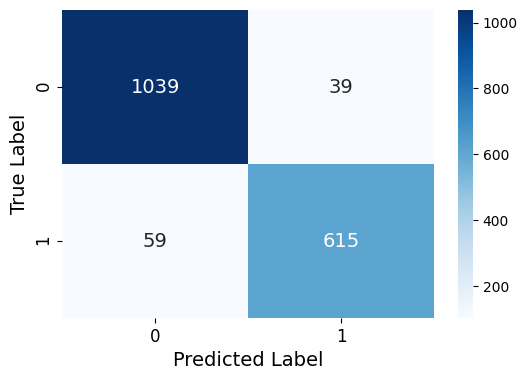


G1 - Non-linear Classifier - Decision Tree
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95      1078
         1.0       0.95      0.90      0.92       674

    accuracy                           0.94      1752
   macro avg       0.95      0.94      0.94      1752
weighted avg       0.94      0.94      0.94      1752

Confusion Matrix:
[[1047   31]
 [  68  606]]


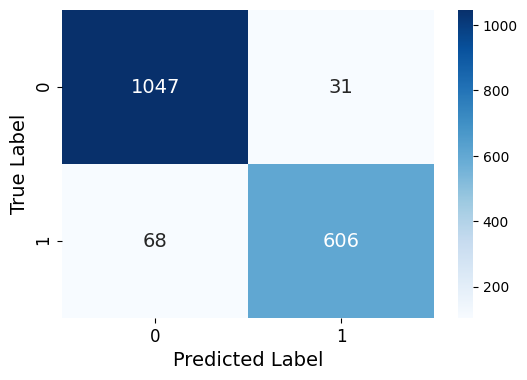


G1 - Non-linear Classifier - Random Forest
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96      1078
         1.0       0.97      0.90      0.93       674

    accuracy                           0.95      1752
   macro avg       0.95      0.94      0.95      1752
weighted avg       0.95      0.95      0.95      1752

Confusion Matrix:
[[1057   21]
 [  66  608]]


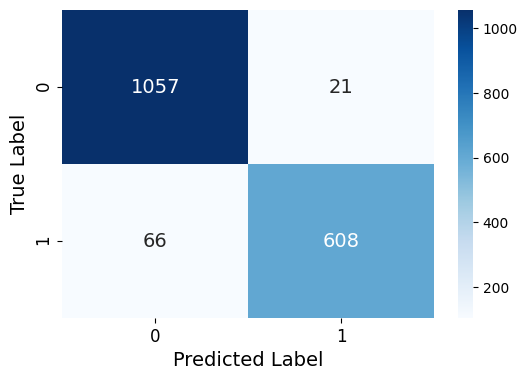


Training models for G2...

G2 - Linear Classifier - Logistic Regression
              precision    recall  f1-score   support

         0.0       1.00      0.03      0.06        33
         1.0       0.98      1.00      0.99      1719

    accuracy                           0.98      1752
   macro avg       0.99      0.52      0.52      1752
weighted avg       0.98      0.98      0.97      1752

Confusion Matrix:
[[   1   32]
 [   0 1719]]


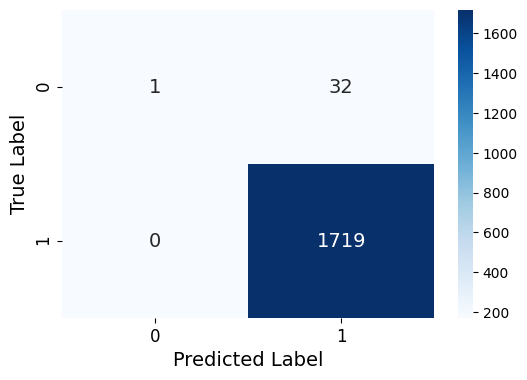


G2 - Non-linear Classifier - Decision Tree
              precision    recall  f1-score   support

         0.0       0.79      0.58      0.67        33
         1.0       0.99      1.00      0.99      1719

    accuracy                           0.99      1752
   macro avg       0.89      0.79      0.83      1752
weighted avg       0.99      0.99      0.99      1752

Confusion Matrix:
[[  19   14]
 [   5 1714]]


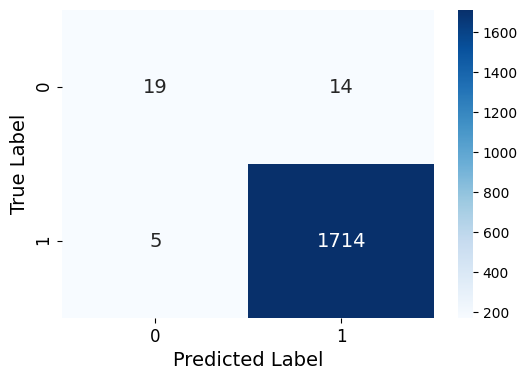


G2 - Non-linear Classifier - Random Forest
              precision    recall  f1-score   support

         0.0       0.79      0.58      0.67        33
         1.0       0.99      1.00      0.99      1719

    accuracy                           0.99      1752
   macro avg       0.89      0.79      0.83      1752
weighted avg       0.99      0.99      0.99      1752

Confusion Matrix:
[[  19   14]
 [   5 1714]]


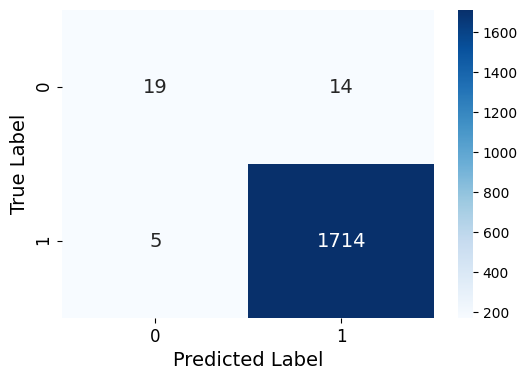


Training models for G3...

G3 - Linear Classifier - Logistic Regression
              precision    recall  f1-score   support

         0.0       0.89      0.87      0.88       886
         1.0       0.87      0.89      0.88       866

    accuracy                           0.88      1752
   macro avg       0.88      0.88      0.88      1752
weighted avg       0.88      0.88      0.88      1752

Confusion Matrix:
[[769 117]
 [ 93 773]]


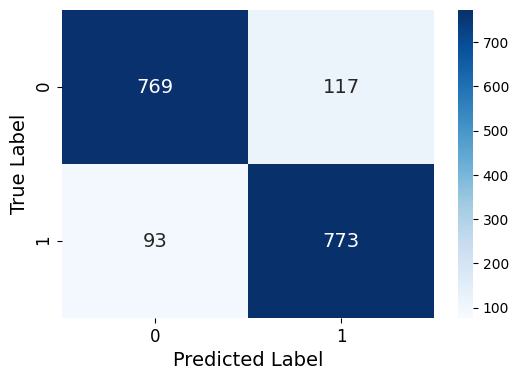


G3 - Non-linear Classifier - Decision Tree
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89       886
         1.0       0.89      0.90      0.89       866

    accuracy                           0.89      1752
   macro avg       0.89      0.89      0.89      1752
weighted avg       0.89      0.89      0.89      1752

Confusion Matrix:
[[790  96]
 [ 90 776]]


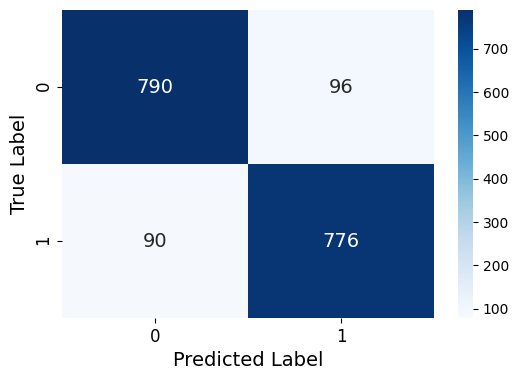


G3 - Non-linear Classifier - Random Forest
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89       886
         1.0       0.89      0.89      0.89       866

    accuracy                           0.89      1752
   macro avg       0.89      0.89      0.89      1752
weighted avg       0.89      0.89      0.89      1752

Confusion Matrix:
[[791  95]
 [ 94 772]]


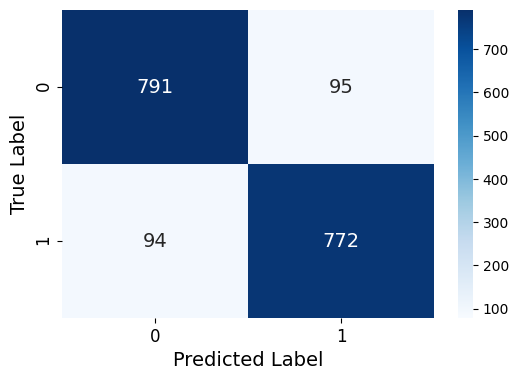

In [20]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import Binarizer
import os

folder_path = "figures"

def plot_confusion_matrix(cm, class_names, file_name=None, folder_path=None):
    plt.figure(figsize=(6, 4))  
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, annot_kws={'size': 14}, vmin=0.1 * np.max(cm), vmax=np.max(cm))
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.xticks(np.arange(len(class_names)) + 0.5, class_names, fontsize=12)
    plt.yticks(np.arange(len(class_names)) + 0.5, class_names, fontsize=12)

    if file_name and folder_path:
        # directory to save the figure if not there already
        os.makedirs(folder_path, exist_ok=True)
        # Save figure 
        plt.savefig(os.path.join(folder_path, f'{file_name}.jpg'), dpi=300, bbox_inches='tight')

    plt.show()


def train_and_evaluate(gen):
    print(f"\nTraining models for {gen}...")

    # features for the generator classification
    features = ['W1_output', 'W2_output', 'Net_demand', f'{gen}_prev_status', f'{gen}_prev_output']
    X = data[features]
    y = data[f'{gen}_status']

    # convert continuous target variable to categorical 
    if y.dtype.kind in 'fc':  
        binarizer = Binarizer(threshold=0.5)  
        y = binarizer.fit_transform(y.values.reshape(-1, 1)).ravel()

    # Split data into train test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Linear classifier - Logistic Regression
    linear_model = LogisticRegression()
    # Hyperparameter tuning 
    param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100]}
    grid_search_lr = GridSearchCV(linear_model, param_grid_lr, cv=3)
    grid_search_lr.fit(X_train, y_train)
    best_linear_model = grid_search_lr.best_estimator_
    y_pred_linear = best_linear_model.predict(X_test)

    # Non-linear classifier - Decision Tree
    nonlinear_model_DT = DecisionTreeClassifier()
    # Hyperparameter tuning 
    param_grid_dt = {'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 5, 10]}
    grid_search_dt = GridSearchCV(nonlinear_model_DT, param_grid_dt, cv=3)
    grid_search_dt.fit(X_train, y_train)
    best_nonlinear_model_DT = grid_search_dt.best_estimator_
    y_pred_nonlinear_DT = best_nonlinear_model_DT.predict(X_test)

    # Non-linear classifier - Random Forest
    nonlinear_model_RF = RandomForestClassifier()
    # Hyperparameter tuning 
    param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 10, None]}
    grid_search_rf = GridSearchCV(nonlinear_model_RF, param_grid_rf, cv=3)
    grid_search_rf.fit(X_train, y_train)
    best_nonlinear_model_RF = grid_search_rf.best_estimator_
    y_pred_nonlinear_RF = best_nonlinear_model_RF.predict(X_test)

    # Evaluate models + print figures for confusion matrix
    print(f"\n{gen} - Linear Classifier - Logistic Regression")
    print(classification_report(y_test, y_pred_linear))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_linear))
    cm_test_linear = confusion_matrix(y_test, y_pred_linear)
    plot_confusion_matrix(cm_test_linear, class_names=['0', '1'], file_name=f"{gen}_Logistic_Regression_CM", folder_path=folder_path)

    print(f"\n{gen} - Non-linear Classifier - Decision Tree")
    print(classification_report(y_test, y_pred_nonlinear_DT))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_nonlinear_DT))
    cm_test_nonlinear_DT = confusion_matrix(y_test, y_pred_nonlinear_DT)
    plot_confusion_matrix(cm_test_nonlinear_DT, class_names=['0', '1'], file_name=f"{gen}_Decision_Tree_CM", folder_path=folder_path)

    print(f"\n{gen} - Non-linear Classifier - Random Forest")
    print(classification_report(y_test, y_pred_nonlinear_RF))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_nonlinear_RF))
    cm_test_nonlinear_RF = confusion_matrix(y_test, y_pred_nonlinear_RF)
    plot_confusion_matrix(cm_test_nonlinear_RF, class_names=['0', '1'], file_name=f"{gen}_Random_Forest_CM", folder_path=folder_path)

# Train and evaluate models for each generator
generators = ['G1', 'G2', 'G3']
for gen in generators:
    train_and_evaluate(gen)

